# Problema

Problema propune gasirea a celor mai bune modele pentru predictia unor autori pe baza unor texte ale acestora (din care trebuiesc extrase feature-uri). Pentru predictia claselor se vor incerca modele de clasificare (SVM) cat si modele de clustering (DBCAN, KMeans and Hierarchical(Agglomerative)).

Setul de date contine 20 de autori cu cate 20 de texte fiecare din care trebuiesc extrase feature-uri. Mai jos sunt prezentate abordarile alese pentru setul de date si modelele alese.

In [26]:
# imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, silhouette_score, completeness_score

%matplotlib inline

# Prelucrarea setului de date

Setul de date contine 20 de autori cu 20 de texte fiecare. Pentru ca este nevoie sa utilizam valori numerice pentru antrenare si predictie s-a ales utilizarea tf-idf vectorizer.

In [27]:
dataset = pd.read_csv("Holteiu N. Daniel-Ninel.csv")

Primul pas este schimbarea setului de date intr-un dataframe care contine 2 coloane: "text" care contine toate textele tuturor autorilor si "author" care contine valori intre 0 si 19 (encodarile autorilor - labels).

In [30]:
# encodarea tuturor autorilor cu valori de la 0 la 19
all_authors = list(dataset.columns.values)
all_authors.pop(0)
authors_dictionary = {author: index for index, author in enumerate(all_authors)}

In [31]:
new_dataset = pd.DataFrame(columns=["text", "author"])
for el in authors_dictionary:
    aux = pd.DataFrame(columns=["text"])
    aux["text"] = dataset[el]
    aux["author"] = pd.Series([authors_dictionary.get(el)] * len(dataset[el]))
    new_dataset = new_dataset.append(aux)

In [32]:
new_dataset

,text,author
0,Ripon Cathedral to the beginning of the fiftee...,0
1,the wall. She paused unable to pronounce his n...,0
2,"therefore shall she not be removed."" It seems...",0
3,"my hero,' said one of the girls. 'Such a charm...",0
4,Who waits upon a dainty point of honour To clu...,0
5,"or whither shall I flee from Thy Spirit?"" Ah ...",0
6,"her prayer from afar off with ""Keep quiet, I a...",0
7,They had shown what was in their evil hearts. ...,0
8,life than the mere life which must be kept up ...,0
9,resurrection of the dead I am called in questi...,0


In [33]:
new_dataset = new_dataset.sample(frac=1).reset_index(drop=True) # shuffle data inside the new dataset

# Impartirea datelor in features (X) - Labels (y)

Se aplica algoritmul TfidfVectorizer pentru calcularea setului de date X (features) din textele date. Se va renuntat la cuvintele care nu sunt in engleza.

In [34]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
X = vectorizer.fit_transform(new_dataset.text)
y = new_dataset.author
y = y.astype('int')

In [35]:
X.shape

(400, 145468)

# Plotarea setului de date

Pentru a putea plota setul de date (clasele / autorii) trebuie sa reducem dimensionalitatea setului de feature-urilor. Astfel vom folosi algoritmul PCA. Pentru ca TfidfVectorizer returneaza un obiect care nu poate fi folosit de PCA (conform documentatiei) s-a folosit echivalentul acestuia - TruncatedSVD.

In [36]:
pca_classifier = TruncatedSVD(n_components=3)
Xpca_plot = pca_classifier.fit_transform(X)
Xpca_plot = pd.DataFrame(Xpca_plot)
y_plot = pd.DataFrame(y)

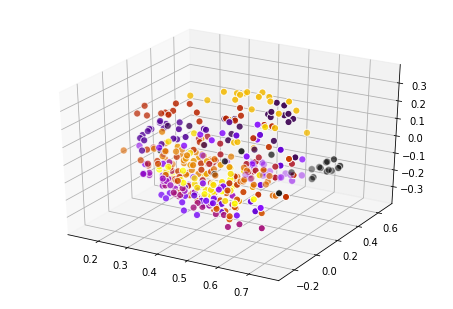

In [37]:
# plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xpca_plot[0], Xpca_plot[1], Xpca_plot[2], c=y_plot["author"], s=50,
           cmap="gnuplot",
           edgecolor="white", linewidth=1)

# Task 1 - Gasirea celui mai bun model SVC

Impartirea setului de date in set de antrenare si set de test.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y) # split data into train and test

S-au folosit diferiti parametrii pentru SVC. S-a facut antrenarea pe setul de antrenare apoi s-au extras 3 scoruri: accuracy, precision, f1_score. Cel mai bun model este considerat cel cu cea mai mare acuratete.

In [39]:
best_svc_model = (None, None, -1.0, -1.0, -1.0)
variated_models = [
                   (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "rbf"}), 
                   (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "rbf"}),
                   (SVC, {"C": 0.1, "gamma": 0.0001, "kernel": "rbf"}),
                   (SVC, {"C": 0.5, "gamma": 1.0, "kernel": "rbf"}),
                   (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "linear"}),
                   (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "linear"}),
                   (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "poly"}),
                   (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "poly"}),
                  ]

for i, (Model, kwargs) in enumerate(variated_models):
    accuracy = 0.0
    precision = 0.0
    f1_score_ = 0.0
    model = Model(**kwargs)
    model.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(x_test))
    precision = precision_score(y_test, model.predict(x_test), average="weighted")
    f1_score_ = f1_score(y_test, model.predict(x_test), average="weighted")
    # get best model to print after
    if best_svc_model[2] < accuracy:
        best_svc_model = (model, kwargs, accuracy, precision, f1_score_)
    print(Model.__name__, kwargs)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("f1 score:", f1_score_)
    print("--------------------------------------------------------------------------------------------------------")
    print()

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.78
Precision: 0.9275757575757575
f1 score: 0.8156767676767678
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.31
Precision: 0.49014705882352944
f1 score: 0.356012077294686
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.95
Precision: 0.9611111111111111
f1 score:

In [41]:
# Cel mai bun model SVC
print("Best SVC model")
print(best_svc_model[1])
print("Accuracy:", best_svc_model[2])
print("Precision:", best_svc_model[3])
print("f1 score:", best_svc_model[4])

Best SVC model
{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.95
Precision: 0.9611111111111111
f1 score: 0.9527284610814022


Pentru ca avem o dimensionalitate foarte mare a datelor (~145000 valori pentru fiecare text) dintre care foarte multe valori de 0, s-a ales incercarea reducerii dimensionalitatii datelor pentru a vedea daca se imbunatatesc rezultatele.

In [42]:
# SVC with PCA
best_svc_model = [(None, None, -1.0, -1.0, -1.0)] * len(pca_dimensions_list)
pca_dimensions_list = [400, 200, 100, 60] # diferite valori ale dimensiunii
for j, pca_dimensions in enumerate(pca_dimensions_list):
    clf = TruncatedSVD(n_components=pca_dimensions)
    Xpca = clf.fit_transform(X)
    variated_models = [
                       (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "rbf"}), 
                       (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "rbf"}),
                       (SVC, {"C": 0.1, "gamma": 0.0001, "kernel": "rbf"}),
                       (SVC, {"C": 0.5, "gamma": 1.0, "kernel": "rbf"}),
                       (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "linear"}),
                       (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "linear"}),
                       (SVC, {"C": 1.0, "gamma": 0.0001, "kernel": "poly"}),
                       (SVC, {"C": 1.0, "gamma": 1.0, "kernel": "poly"}),
                      ]
    x_train, x_test, y_train, y_test = train_test_split(Xpca, y) # split data into train and set
    print("For PCA with dimensions:", pca_dimensions)
    for i, (Model, kwargs) in enumerate(variated_models):
        accuracy = 0.0
        precision = 0.0
        f1_score_ = 0.0
        model = Model(**kwargs)
        model.fit(x_train, y_train)
        accuracy = accuracy_score(y_test, model.predict(x_test))
        precision = precision_score(y_test, model.predict(x_test), average="weighted")
        f1_score_ = f1_score(y_test, model.predict(x_test), average="weighted")
        # get best model to print after
        if best_svc_model[j][2] < accuracy:
            best_svc_model[j] = (model, kwargs, accuracy, precision, f1_score_)
        print(Model.__name__, kwargs)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("f1 score:", f1_score_)
        print("--------------------------------------------------------------------------------------------------------")
        print()


For PCA with dimensions: 400
SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.92
Precision: 0.9498333333333333
f1 score: 0.9233015873015873
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metr

SVC {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.34
Precision: 0.49058823529411766
f1 score: 0.3762142857142857
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.98
Precision: 0.9845
f1 score: 0.9798152958152957
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
Accuracy: 0.98
Precision: 0.9845
f1 score: 0.9798152958152957
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'poly'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'poly'}
Accuracy: 0.79
Precision: 0.9399025974025974
f1 score: 0.821147186147186
--------------------------------------------------------------------------------------------------------

For PCA with dimensions: 200
SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.79
Precision: 0.898690476190476
f1 score: 0.8126342448401271
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metr

SVC {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.56
Precision: 0.7296701754385964
f1 score: 0.555376567876568
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.91
Precision: 0.9377738095238096
f1 score: 0.9132511932511931
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
Accuracy: 0.91
Precision: 0.9377738095238096
f1 score: 0.9132511932511931
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metr

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'poly'}
Accuracy: 0.02
Precision: 0.0004
f1 score: 0.000784313725490196
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'poly'}
Accuracy: 0.66
Precision: 0.8545230769230769
f1 score: 0.6867954545454547
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For PCA with dimensions: 100
SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.88
Precision: 0.9833333333333333
f1 score: 0.9155918525918526
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.77
Precision: 0.8946212121212122
f1 score: 0.802653781001607
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.95
Precision: 

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metr

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
Accuracy: 0.95
Precision: 0.9766666666666667
f1 score: 0.9558037518037519
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'poly'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'poly'}
Accuracy: 0.51
Precision: 0.835579365079365
f1 score: 0.5673733995473125
--------------------------------------------------------------------------------------------------------



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For PCA with dimensions: 60
SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.94
Precision: 0.9703333333333333
f1 score: 0.9462185592185592
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.01
Precision: 0.0001
f1 score: 0.00019801980198019803
--------------------------------------------------------------------------------------------------------

SVC {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.82
Precision: 0.9587692307692308
f1 score: 0.8453748196248196
--------------------------------------------------------------------------------------------------------

SVC {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.92
Precision: 

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metr

In [91]:
# show best results with PCA
for i, dimensions in enumerate(pca_dimensions_list):
    print("Best results for PCA with dimensions:", dimensions)
    print(best_svc_model[i][1])
    print("Accuracy:", best_svc_model[i][2])
    print("Precision:", best_svc_model[i][3])
    print("f1 score:", best_svc_model[i][4])
    print("===============================")

Best results for PCA with dimensions: 400
{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.98
Precision: 0.9845
f1 score: 0.9798152958152957
Best results for PCA with dimensions: 200
{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.91
Precision: 0.9377738095238096
f1 score: 0.9132511932511931
Best results for PCA with dimensions: 100
{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Accuracy: 0.95
Precision: 0.9766666666666667
f1 score: 0.9558037518037519
Best results for PCA with dimensions: 60
{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy: 0.94
Precision: 0.9703333333333333
f1 score: 0.9462185592185592


Conform rezultatelor de mai sus putem concluziona ca se pot imbunatatii rezultatele algoritmului prin reducerea dimensionalitatii datelor.

# Task 2 - Gasirea celor mai buni algoritmi de clusterizare

Avand in vedere ca se vor folosi algoritmi de clustering, nu este nevoie sa impartim setul de date in set de antrenare si set de test.

Se vor cauta cei mai buni hiperparametrii pentru algoritmii de clusterizare

Vom considera "cel mai bun model" ca fiind acela cu cel mai mare "silhouette score". Totusi toate modelele vor fi afisate impreuna cu toate rezultatele lor.

# Gasirea celui mai bun model DBSCAN

In [99]:
best_dbscan_model = (None, None, -1.0, -1.0, -1.0)
eps_values = np.arange(0.5, 2, 0.1)
min_samples_values = np.arange(2, 6, 1)
variated_models = []
for eps_val in eps_values:
    for min_sample in min_samples_values:
        variated_models.append((DBSCAN, {"eps": eps_val, "min_samples": min_sample}))

for i, (Model, kwargs) in enumerate(variated_models):
    homogeneity = 0.0
    silhouette = 0.0
    completeness = 0.0
    model = Model(**kwargs)
    model.fit(X)
    unique, counts = np.unique(model.labels_, return_counts=True)
    if len(dict(zip(unique, counts))) > 1:
        homogeneity = homogeneity_score(y, model.labels_)
        silhouette = silhouette_score(X, model.labels_)
        completeness = completeness_score(y, model.labels_)
        # get best model to print after
        if best_dbscan_model[3] < silhouette:
            best_dbscan_model = (model, kwargs, homogeneity, silhouette, completeness)
    print(Model.__name__, kwargs)
    print(dict(zip(unique, counts)))
    print("Homogeneity:", homogeneity)
    print("Silhouette:", silhouette)
    print("Completeness:", completeness)
    print("--------------------------------------------------------------------------------------------------------")
    print()

DBSCAN {'eps': 0.5, 'min_samples': 2}
{-1: 371, 0: 2, 1: 2, 2: 4, 3: 2, 4: 2, 5: 5, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2}
Homogeneity: 0.07437042460484723
Silhouette: -0.03472724390307181
Completeness: 0.5115244302741193
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 3}
{-1: 391, 0: 4, 1: 5}
Homogeneity: 0.023344913667750385
Silhouette: -0.05554616563940412
Completeness: 0.5682455566458954
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 4}
{-1: 395, 0: 5}
Homogeneity: 0.013045265585564075
Silhouette: -0.026873347214737612
Completeness: 0.5815764499902554
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 5}
{-1: 395, 0: 5}
Homogeneity: 0.013045265585564075
Silhouette: -0.026873347214737612
Completeness: 0.58157644

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 2}
{-1: 62, 0: 293, 1: 9, 2: 2, 3: 6, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2}
Homogeneity: 0.1667925553498778
Silhouette: 0.04612882448649524
Completeness: 0.47287719603997713
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 3}
{-1: 86, 0: 293, 1: 9, 2: 6, 3: 3, 4: 3}
Homogeneity: 0.11025518913582491
Silhouette: 0.02395778860852585
Completeness: 0.4233138901711245
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 4}
{-1: 97, 0: 288, 1: 9, 2: 6}
Homogeneity: 0.10183755614509062
Silhouette: 0.03487479631188819
Completeness: 0.41880343887880495
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'mi

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------



In [100]:
# Cel mai bun model DBSCAN
print("Best DBSCAN model")
print(best_dbscan_model[1])
print("Homogeneity:", best_dbscan_model[2])
print("Silhouette:", best_dbscan_model[3])
print("Completeness:", best_dbscan_model[4])

Best DBSCAN model
{'eps': 0.8999999999999999, 'min_samples': 2}
Homogeneity: 0.5177705862398834
Silhouette: 0.08452476299351507
Completeness: 0.6252502343495219


Rezultatele pentru DBSCAN nu sunt foarte promitatoare. In majoritatea cazurilor avem clustere mici (fie multe fie putine) cu multe ouliere. De la o anumita valoare a lui epsilon se gaseste un sigur cluster cu toate textele.

### Reducerea dimensionalitatii datelor

In [150]:
# DBSCAN with PCA
pca_dimensions_list = [400, 200, 100, 60, 10, 5, 3] # diferite valori ale dimensiunii
best_dbscan_model = [(None, None, -1.0, -1.0, -1.0)] * len(pca_dimensions_list)
for j, pca_dimensions in enumerate(pca_dimensions_list):
    clf = TruncatedSVD(n_components=pca_dimensions)
    Xpca = clf.fit_transform(X)
    eps_values = np.arange(0.5, 2, 0.1)
    min_samples_values = np.arange(2, 6, 1)
    variated_models = []
    for eps_val in eps_values:
        for min_sample in min_samples_values:
            variated_models.append((DBSCAN, {"eps": eps_val, "min_samples": min_sample}))
    print("Dimensions:", pca_dimensions)
    for i, (Model, kwargs) in enumerate(variated_models):
        homogeneity = 0.0
        silhouette = 0.0
        completeness = 0.0
        model = Model(**kwargs)
        model.fit(Xpca)
        unique, counts = np.unique(model.labels_, return_counts=True)
        if len(dict(zip(unique, counts))) > 1:
            homogeneity = homogeneity_score(y, model.labels_)
            silhouette = silhouette_score(Xpca, model.labels_)
            completeness = completeness_score(y, model.labels_)
            # get best model to print after
            if best_dbscan_model[j][3] < silhouette:
                best_dbscan_model[j] = (model, kwargs, homogeneity, silhouette, completeness)
        print(Model.__name__, kwargs)
        print(dict(zip(unique, counts)))
        print("Homogeneity:", homogeneity)
        print("Silhouette:", silhouette)
        print("Completeness:", completeness)
        print("--------------------------------------------------------------------------------------------------------")
        print()


Dimensions: 400
DBSCAN {'eps': 0.5, 'min_samples': 2}
{-1: 371, 0: 2, 1: 2, 2: 4, 3: 2, 4: 2, 5: 5, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2}
Homogeneity: 0.07437042460484723
Silhouette: -0.034727243903072524
Completeness: 0.5115244302741193
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 3}
{-1: 391, 0: 4, 1: 5}
Homogeneity: 0.023344913667750385
Silhouette: -0.05554616563940543
Completeness: 0.5682455566458954
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 4}
{-1: 395, 0: 5}
Homogeneity: 0.013045265585564075
Silhouette: -0.02687334721473757
Completeness: 0.5815764499902554
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 5}
{-1: 395, 0: 5}
Homogeneity: 0.013045265585564075
Silhouette: -0.02687334721473757
Completen

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 2}
{-1: 62, 0: 293, 1: 9, 2: 2, 3: 6, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2}
Homogeneity: 0.1667925553498778
Silhouette: 0.046128824486496474
Completeness: 0.47287719603997713
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 3}
{-1: 86, 0: 293, 1: 9, 2: 6, 3: 3, 4: 3}
Homogeneity: 0.11025518913582491
Silhouette: 0.023957788608526275
Completeness: 0.4233138901711245
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 4}
{-1: 97, 0: 288, 1: 9, 2: 6}
Homogeneity: 0.10183755614509062
Silhouette: 0.034874796311888744
Completeness: 0.41880343887880495
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 

Dimensions: 200
DBSCAN {'eps': 0.5, 'min_samples': 2}
{-1: 173, 0: 49, 1: 6, 2: 2, 3: 2, 4: 2, 5: 2, 6: 20, 7: 6, 8: 2, 9: 2, 10: 2, 11: 12, 12: 2, 13: 5, 14: 3, 15: 7, 16: 2, 17: 3, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 3, 24: 2, 25: 2, 26: 2, 27: 3, 28: 5, 29: 4, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 3, 41: 2, 42: 3, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 2, 49: 2, 50: 2, 51: 3, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 3, 58: 2, 59: 2, 60: 2}
Homogeneity: 0.5218275704137205
Silhouette: 0.16435975927919252
Completeness: 0.5797359466619885
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 3}
{-1: 259, 0: 6, 1: 20, 2: 6, 3: 49, 4: 12, 5: 5, 6: 3, 7: 7, 8: 3, 9: 3, 10: 5, 11: 4, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3}
Homogeneity: 0.3006952530088249
Silhouette: 0.00570030791209093
Completeness: 0.6101860327799409
-------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 4}
{-1: 6, 0: 394}
Homogeneity: 0.007318848972554402
Silhouette: 0.12080758832492458
Completeness: 0.2815177918397294
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.0999999999999999, 'min_samples': 5}
{-1: 6, 0: 394}
Homogeneity: 0.007318848972554402
Silhouette: 0.12080758832492458
Completeness: 0.2815177918397294
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.1999999999999997, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.1999999999999997, 'min_samples': 3}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps':

DBSCAN {'eps': 0.6, 'min_samples': 2}
{-1: 14, 0: 298, 1: 2, 2: 10, 3: 2, 4: 2, 5: 6, 6: 2, 7: 2, 8: 3, 9: 3, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 3, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 3, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2}
Homogeneity: 0.24474385921484096
Silhouette: 0.15762515877491987
Completeness: 0.5115051363311511
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.6, 'min_samples': 3}
{-1: 74, 0: 298, 1: 10, 2: 6, 3: 3, 4: 3, 5: 3, 6: 3}
Homogeneity: 0.1124068141057893
Silhouette: 0.04597390849527622
Completeness: 0.40401849975606363
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.6, 'min_samples': 4}
{-1: 98, 0: 287, 1: 9, 2: 6}
Homogeneity: 0.08472356331384602
Silhouette: 0.10681190214723489
Completeness: 0.3471344450627214
------------------------------------

DBSCAN {'eps': 1.4, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.4, 'min_samples': 3}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.4, 'min_samples': 4}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.4, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.4999999999999998, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
-----------------------------------------------------------------------

DBSCAN {'eps': 0.7999999999999999, 'min_samples': 3}
{-1: 10, 0: 390}
Homogeneity: 0.014395238964643599
Silhouette: 0.2706362419591709
Completeness: 0.3688772922206878
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.7999999999999999, 'min_samples': 4}
{-1: 11, 0: 389}
Homogeneity: 0.01409778385638711
Silhouette: 0.2681144330004062
Completeness: 0.33533966887403566
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.7999999999999999, 'min_samples': 5}
{-1: 12, 0: 388}
Homogeneity: 0.013722213103771237
Silhouette: 0.2651158286924864
Completeness: 0.30508694653561336
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.8999999999999999, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
----------------------------------------------------------------

DBSCAN {'eps': 1.7999999999999998, 'min_samples': 4}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.7999999999999998, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 3}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 4}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
-----------

Dimensions: 5
DBSCAN {'eps': 0.5, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 3}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 4}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.5, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 0.6, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
------------------------------------------------------------------------

DBSCAN {'eps': 1.7999999999999998, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 2}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 3}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 4}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
--------------------------------------------------------------------------------------------------------

DBSCAN {'eps': 1.8999999999999997, 'min_samples': 5}
{0: 400}
Homogeneity: 0.0
Silhouette: 0.0
Completeness: 0.0
-----------

In [151]:
# show best results with PCA
for i, dimensions in enumerate(pca_dimensions_list):
    print("Best results for PCA with dimensions:", dimensions)
    print(best_dbscan_model[i][1])
    print("Homogeneity:", best_dbscan_model[i][2])
    print("Silhouette:", best_dbscan_model[i][3])
    print("Completeness:", best_dbscan_model[i][4])
    print("===============================")

Best results for PCA with dimensions: 400
{'eps': 0.8999999999999999, 'min_samples': 2}
Homogeneity: 0.5177705862398834
Silhouette: 0.08452476299351452
Completeness: 0.6252502343495219
Best results for PCA with dimensions: 200
{'eps': 0.6, 'min_samples': 2}
Homogeneity: 0.4558583810370494
Silhouette: 0.17713013515375134
Completeness: 0.5234302383088102
Best results for PCA with dimensions: 100
{'eps': 0.5, 'min_samples': 2}
Homogeneity: 0.4597232368610279
Silhouette: 0.22834519087736774
Completeness: 0.5413251179646243
Best results for PCA with dimensions: 60
{'eps': 0.8999999999999999, 'min_samples': 5}
Homogeneity: 0.0038813687442054157
Silhouette: 0.29218420698036424
Completeness: 0.3693737810421438
Best results for PCA with dimensions: 10
None
Homogeneity: -1.0
Silhouette: -1.0
Completeness: -1.0
Best results for PCA with dimensions: 5
None
Homogeneity: -1.0
Silhouette: -1.0
Completeness: -1.0
Best results for PCA with dimensions: 3
None
Homogeneity: -1.0
Silhouette: -1.0
Completen

Conform rezultatelor de mai sus, se pare ca prin reducerea dimensionalitatii cresc scorurile, insa rezultatele tot nu sunt rezultate foarte bune pentru ca toate textele sunt clusterizate in acelasi cluster sau in foarte putine clustere. Totusi se pare ca numarul oulierelor scade.

# Gasirea celui mai bun model KMeans

In [107]:
best_kmeans_model = (None, None, -1.0, -1.0, -1.0)
n_clusters_values = np.arange(2, 20, 1) # valori mai mari pentru ca stim deja ca, in teorie, ar trebuii sa fie 20 clustere.
                                         # Consider ca nu are niciun sens sa alegem valori mici pentru n_clusters
init_values = ['k-means++', 'random']
variated_models = []
for n in n_clusters_values:
    for init in init_values:
        variated_models.append((KMeans, {"n_clusters": n, "init": init}))

for i, (Model, kwargs) in enumerate(variated_models):
    print(Model.__name__, kwargs)
    homogeneity = 0.0
    silhouette = 0.0
    completeness = 0.0
    model = Model(**kwargs)
    model.fit(X)
    unique, counts = np.unique(model.labels_, return_counts=True)
    homogeneity = homogeneity_score(y, model.labels_)
    silhouette = silhouette_score(X, model.labels_)
    completeness = completeness_score(y, model.labels_)
    # get best model to print after
    if best_kmeans_model[3] < silhouette:
        best_kmeans_model = (model, kwargs, homogeneity, silhouette, completeness)
    print("Homogeneity:", homogeneity)
    print("Silhouette:", silhouette)
    print("Completeness:", completeness)
    print("--------------------------------------------------------------------------------------------------------")
    print()

KMeans {'n_clusters': 2, 'init': 'k-means++'}
Homogeneity: 0.15171909134117156
Silhouette: 0.029725280682696562
Completeness: 0.6925959640555656
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 2, 'init': 'random'}
Homogeneity: 0.10048588931683078
Silhouette: 0.0217882371299594
Completeness: 0.7790869011894967
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 3, 'init': 'k-means++'}
Homogeneity: 0.19921306436931288
Silhouette: 0.03045681343306069
Completeness: 0.6717837459540532
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 3, 'init': 'random'}
Homogeneity: 0.22994781472142353
Silhouette: 0.029594254931532237
Completeness: 0.7300477459617666
--------------------------------------------------------------------------------------------------------

KMean

Homogeneity: 0.5236517783443692
Silhouette: 0.0268037622153296
Completeness: 0.704527129267108
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 19, 'init': 'k-means++'}
Homogeneity: 0.5542194740945612
Silhouette: 0.03529827158030816
Completeness: 0.693239175545131
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 19, 'init': 'random'}
Homogeneity: 0.5244088739307906
Silhouette: 0.04052783580893408
Completeness: 0.6788276429182784
--------------------------------------------------------------------------------------------------------



In [108]:
# Cel mai bun model KMeans
print("Best KMeans model")
print(best_kmeans_model[1])
print("Homogeneity:", best_kmeans_model[2])
print("Silhouette:", best_kmeans_model[3])
print("Completeness:", best_kmeans_model[4])

Best KMeans model
{'n_clusters': 11, 'init': 'k-means++'}
Homogeneity: 0.39135987303525255
Silhouette: 0.05547427834124458
Completeness: 0.7286020215433437


Cel mai bun model are silhouette score-ul foarte mic (aproape de 0). Asta inseamna ca se suprapun clusterele.

### Reducerea dimensionalitatii folosing PCA

In [137]:
# KMeans with PCA
pca_dimensions_list = [400, 60, 10, 5, 3] # diferite valori ale dimensiunii
best_kmeans_model = [(None, None, -1.0, -1.0, -1.0)] * len(pca_dimensions_list)
for j, pca_dimensions in enumerate(pca_dimensions_list):
    clf = TruncatedSVD(n_components=pca_dimensions)
    Xpca = clf.fit_transform(X)
    n_clusters_values = np.arange(15, 21, 1) # reducing number of clusters to try because it takes too much time
    init_values = ['k-means++', 'random']
    variated_models = []
    for n in n_clusters_values:
        for init in init_values:
            variated_models.append((KMeans, {"n_clusters": n, "init": init}))

    print("Dimensions:", pca_dimensions)
    for i, (Model, kwargs) in enumerate(variated_models):
        print(Model.__name__, kwargs)
        homogeneity = 0.0
        silhouette = 0.0
        completeness = 0.0
        model = Model(**kwargs)
        model.fit(Xpca)
        unique, counts = np.unique(model.labels_, return_counts=True)
        homogeneity = homogeneity_score(y, model.labels_)
        silhouette = silhouette_score(Xpca, model.labels_)
        completeness = completeness_score(y, model.labels_)
        # get best model to print after
        if best_kmeans_model[j][3] < silhouette:
            best_kmeans_model[j] = (model, kwargs, homogeneity, silhouette, completeness)
        print("Homogeneity:", homogeneity)
        print("Silhouette:", silhouette)
        print("Completeness:", completeness)
        print("--------------------------------------------------------------------------------------------------------")
        print()


Dimensions: 400
KMeans {'n_clusters': 15, 'init': 'k-means++'}
Homogeneity: 0.4574134920497774
Silhouette: 0.039760227560189
Completeness: 0.7726284521617455
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 15, 'init': 'random'}
Homogeneity: 0.4344454013062587
Silhouette: 0.034816225145436655
Completeness: 0.762870830930227
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 16, 'init': 'k-means++'}
Homogeneity: 0.5262256801243683
Silhouette: 0.032097304569197106
Completeness: 0.7034601474230299
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 16, 'init': 'random'}
Homogeneity: 0.4677147061376691
Silhouette: 0.04439327427266223
Completeness: 0.6511555081593372
-------------------------------------------------------------------------------------------------

Homogeneity: 0.633485336779815
Silhouette: 0.2789636952782488
Completeness: 0.6727536500602063
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 20, 'init': 'k-means++'}
Homogeneity: 0.621017135279498
Silhouette: 0.29429531684449056
Completeness: 0.6733430942029058
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 20, 'init': 'random'}
Homogeneity: 0.6259994995475381
Silhouette: 0.2919197668639456
Completeness: 0.675456168532505
--------------------------------------------------------------------------------------------------------

Dimensions: 5
KMeans {'n_clusters': 15, 'init': 'k-means++'}
Homogeneity: 0.5073133688153585
Silhouette: 0.32705975239439666
Completeness: 0.6250027025630235
--------------------------------------------------------------------------------------------------------

KMeans {'n_clusters': 15, 'init': 'random

In [138]:
# show best results with PCA
for i, dimensions in enumerate(pca_dimensions_list):
    print("Best results for PCA with dimensions:", dimensions)
    print(best_kmeans_model[i][1])
    print("Homogeneity:", best_kmeans_model[i][2])
    print("Silhouette:", best_kmeans_model[i][3])
    print("Completeness:", best_kmeans_model[i][4])
    print("===============================")

Best results for PCA with dimensions: 400
{'n_clusters': 20, 'init': 'k-means++'}
Homogeneity: 0.5672990652726673
Silhouette: 0.05067487566720659
Completeness: 0.6957774130221711
Best results for PCA with dimensions: 60
{'n_clusters': 20, 'init': 'random'}
Homogeneity: 0.5836039199137025
Silhouette: 0.17366600662653472
Completeness: 0.6961685640929288
Best results for PCA with dimensions: 10
{'n_clusters': 20, 'init': 'k-means++'}
Homogeneity: 0.621017135279498
Silhouette: 0.29429531684449056
Completeness: 0.6733430942029058
Best results for PCA with dimensions: 5
{'n_clusters': 15, 'init': 'k-means++'}
Homogeneity: 0.5073133688153585
Silhouette: 0.32705975239439666
Completeness: 0.6250027025630235
Best results for PCA with dimensions: 3
{'n_clusters': 19, 'init': 'k-means++'}
Homogeneity: 0.4655954071647775
Silhouette: 0.32257097414890096
Completeness: 0.49578846639721014


Rezultatele sunt mai bune decat in cazul neutilizarii PCA. Se observa o crestere a Silhouette score-ului. Astfel, desi inca nu sunt rezultate foarte bune, putem deduce ca prin utilizarea PCA se face o clusterizare mai buna.

## Plot al celor mai bune modele - KMeans

### Plot al modelului fara PCA

In [130]:
pca_classifier = TruncatedSVD(n_components=3)
Xpca_plot = pca_classifier.fit_transform(X)
Xpca_plot = pd.DataFrame(Xpca_plot)

In [131]:
model = KMeans(n_clusters=11, init='k-means++')
model.fit(X)
y_plot = pd.DataFrame(model.labels_)

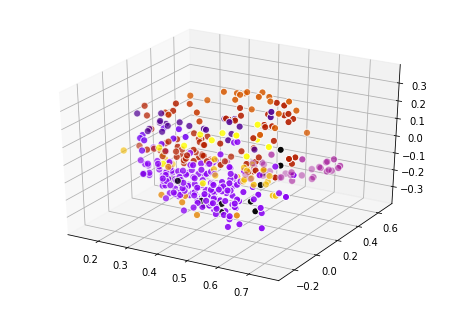

In [132]:
# plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xpca_plot[0], Xpca_plot[1], Xpca_plot[2], c=y_plot[0], s=50,
           cmap="gnuplot",
           edgecolor="white", linewidth=1)

### Plot al modelele in care s-a folosit PCA

KMeans {'n_clusters': 20, 'init': 'k-means++'} -- Dimensions: 400
KMeans {'n_clusters': 20, 'init': 'random'} -- Dimensions: 60
KMeans {'n_clusters': 20, 'init': 'k-means++'} -- Dimensions: 10
KMeans {'n_clusters': 15, 'init': 'k-means++'} -- Dimensions: 5
KMeans {'n_clusters': 19, 'init': 'k-means++'} -- Dimensions: 3


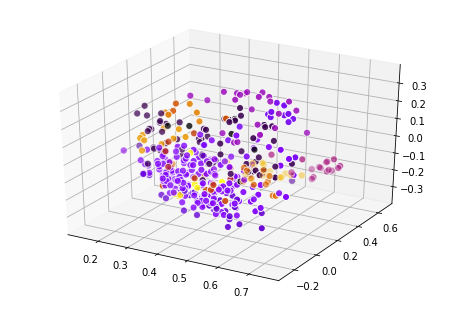

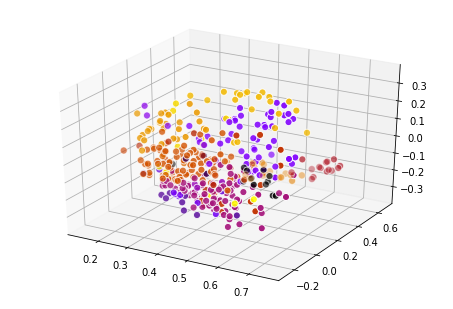

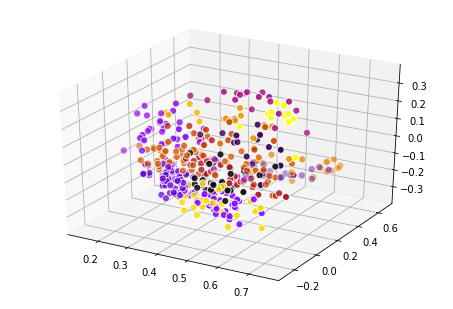

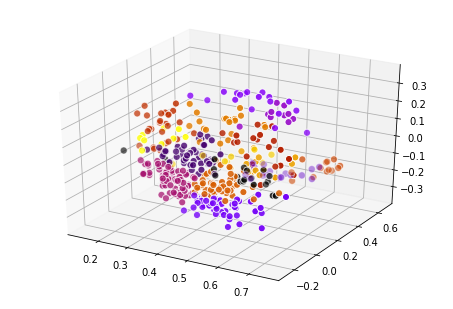

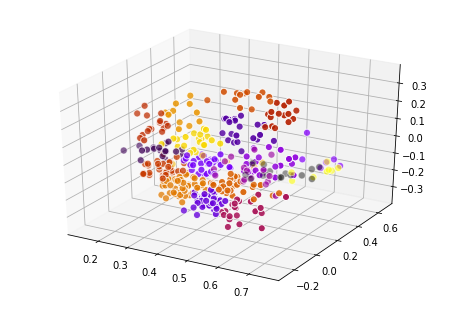

In [140]:
models_list = [
    (KMeans, {'n_clusters': 20, 'init': 'k-means++'}, 400),
    (KMeans, {'n_clusters': 20, 'init': 'random'}, 60),
    (KMeans, {'n_clusters': 20, 'init': 'k-means++'}, 10),
    (KMeans, {'n_clusters': 15, 'init': 'k-means++'}, 5),
    (KMeans, {'n_clusters': 19, 'init': 'k-means++'}, 3)
]
for i, (Model, kwargs, dimensions) in enumerate(models_list):
    print(Model.__name__, kwargs, "-- Dimensions:", dimensions)
    clf = TruncatedSVD(n_components=dimensions)
    Xpca = clf.fit_transform(X)
    model = Model(**kwargs)
    model.fit(Xpca)
    y_plot = pd.DataFrame(model.labels_)
    fig = plt.figure(i)
    ax = Axes3D(fig)
    ax.scatter(Xpca_plot[0], Xpca_plot[1], Xpca_plot[2], c=y_plot[0], s=50,
           cmap="gnuplot",
           edgecolor="white", linewidth=1)

# Gasirea celui mai bun model Agglomerative

In [141]:
best_agglomerative_model = (None, None, -1.0, -1.0, -1.0)
n_clusters_values = np.arange(2, 21, 1)
variated_models = []
for n in n_clusters_values:
    variated_models.append((AgglomerativeClustering, {"n_clusters": n}))

for i, (Model, kwargs) in enumerate(variated_models):
    print(Model.__name__, kwargs)
    homogeneity = 0.0
    silhouette = 0.0
    completeness = 0.0
    model = Model(**kwargs)
    model.fit(X.toarray())
    unique, counts = np.unique(model.labels_, return_counts=True)
    homogeneity = homogeneity_score(y, model.labels_)
    silhouette = silhouette_score(X, model.labels_)
    completeness = completeness_score(y, model.labels_)
    # get best model to print after
    if best_agglomerative_model[3] < silhouette:
        best_agglomerative_model = (model, kwargs, homogeneity, silhouette, completeness)
    print("Homogeneity:", homogeneity)
    print("Silhouette:", silhouette)
    print("Completeness:", completeness)
    print("--------------------------------------------------------------------------------------------------------")
    print()

AgglomerativeClustering {'n_clusters': 2}
Homogeneity: 0.07614500593762971
Silhouette: 0.021977166205767264
Completeness: 0.8008549200684545
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 3}
Homogeneity: 0.22615530093014155
Silhouette: 0.03089091338916804
Completeness: 0.8315949049110025
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 4}
Homogeneity: 0.2673466503681015
Silhouette: 0.03361721433366621
Completeness: 0.8537470462506365
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 5}
Homogeneity: 0.3022893729035926
Silhouette: 0.03588330355062839
Completeness: 0.8684286207765582
--------------------------------------------------------------------------------------------------------

AgglomerativeClus

In [142]:
# Cel mai bun model Agglomerative
print("Best DBSCAN model")
print(best_agglomerative_model[1])
print("Homogeneity:", best_agglomerative_model[2])
print("Silhouette:", best_agglomerative_model[3])
print("Completeness:", best_agglomerative_model[4])

Best DBSCAN model
{'n_clusters': 7}
Homogeneity: 0.43052984632208846
Silhouette: 0.04329673734848599
Completeness: 0.8228930668431953


Se observa ca scorul silhouette este foarte mic.

In [145]:
# Agglomerative with PCA
pca_dimensions_list = [400, 60, 10, 5, 3] # diferite valori ale dimensiunii
best_agglomerative_model = [(None, None, -1.0, -1.0, -1.0)] * len(pca_dimensions_list)
for j, pca_dimensions in enumerate(pca_dimensions_list):
    clf = TruncatedSVD(n_components=pca_dimensions)
    Xpca = clf.fit_transform(X)
    n_clusters_values = np.arange(2, 21, 1) # reducing number of clusters to try because it takes too much time
    variated_models = []
    for n in n_clusters_values:
        variated_models.append((AgglomerativeClustering, {"n_clusters": n}))

    print("Dimensions:", pca_dimensions)
    for i, (Model, kwargs) in enumerate(variated_models):
        print(Model.__name__, kwargs)
        homogeneity = 0.0
        silhouette = 0.0
        completeness = 0.0
        model = Model(**kwargs)
        model.fit(Xpca)
        unique, counts = np.unique(model.labels_, return_counts=True)
        homogeneity = homogeneity_score(y, model.labels_)
        silhouette = silhouette_score(Xpca, model.labels_)
        completeness = completeness_score(y, model.labels_)
        # get best model to print after
        if best_agglomerative_model[j][3] < silhouette:
            best_agglomerative_model[j] = (model, kwargs, homogeneity, silhouette, completeness)
        print("Homogeneity:", homogeneity)
        print("Silhouette:", silhouette)
        print("Completeness:", completeness)
        print("--------------------------------------------------------------------------------------------------------")
        print()


Dimensions: 400
AgglomerativeClustering {'n_clusters': 2}
Homogeneity: 0.07614500593762971
Silhouette: 0.02197716620576613
Completeness: 0.8008549200684545
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 3}
Homogeneity: 0.22615530093014155
Silhouette: 0.03089091338916715
Completeness: 0.8315949049110025
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 4}
Homogeneity: 0.2673466503681015
Silhouette: 0.03361721433366842
Completeness: 0.8537470462506365
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 5}
Homogeneity: 0.3022893729035926
Silhouette: 0.035883303550630456
Completeness: 0.8684286207765582
--------------------------------------------------------------------------------------------------------

A

Homogeneity: 0.6441304463657427
Silhouette: 0.14283774483896028
Completeness: 0.8199245330382106
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 18}
Homogeneity: 0.6497233978795077
Silhouette: 0.1490001848800883
Completeness: 0.8211974929058051
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 19}
Homogeneity: 0.6526356347567039
Silhouette: 0.15630660458135334
Completeness: 0.8163681815697529
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 20}
Homogeneity: 0.6617901591060269
Silhouette: 0.1649007662496325
Completeness: 0.8085589856505105
--------------------------------------------------------------------------------------------------------

Dimensions: 10
AgglomerativeClustering {'n_clusters': 2}
Homo

Dimensions: 3
AgglomerativeClustering {'n_clusters': 2}
Homogeneity: 0.0958421561695345
Silhouette: 0.4879111424544741
Completeness: 0.752391325172516
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 3}
Homogeneity: 0.214662495345834
Silhouette: 0.4014153592816018
Completeness: 0.7186404619564264
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 4}
Homogeneity: 0.24046392089235213
Silhouette: 0.3250527287228586
Completeness: 0.5403539455705895
--------------------------------------------------------------------------------------------------------

AgglomerativeClustering {'n_clusters': 5}
Homogeneity: 0.2484505777665139
Silhouette: 0.32603513934135914
Completeness: 0.5256608643541493
--------------------------------------------------------------------------------------------------------

Agglomerat

In [146]:
# show best results with PCA
for i, dimensions in enumerate(pca_dimensions_list):
    print("Best results for PCA with dimensions:", dimensions)
    print(best_agglomerative_model[i][1])
    print("Homogeneity:", best_agglomerative_model[i][2])
    print("Silhouette:", best_agglomerative_model[i][3])
    print("Completeness:", best_agglomerative_model[i][4])
    print("===============================")

Best results for PCA with dimensions: 400
{'n_clusters': 7}
Homogeneity: 0.43052984632208846
Silhouette: 0.04329673734848681
Completeness: 0.8228930668431953
Best results for PCA with dimensions: 60
{'n_clusters': 20}
Homogeneity: 0.6617901591060269
Silhouette: 0.1649007662496325
Completeness: 0.8085589856505105
Best results for PCA with dimensions: 10
{'n_clusters': 2}
Homogeneity: 0.07532555759419997
Silhouette: 0.39946128089246935
Completeness: 0.7922363740522497
Best results for PCA with dimensions: 5
{'n_clusters': 2}
Homogeneity: 0.07532555759419997
Silhouette: 0.49796724753967964
Completeness: 0.7922363740522497
Best results for PCA with dimensions: 3
{'n_clusters': 2}
Homogeneity: 0.0958421561695345
Silhouette: 0.4879111424544741
Completeness: 0.752391325172516


Rezultatele prin utilizarea PCA se imbunatatesc substantial, daca luam in considerare silhouette score-ul. Dar, cazurile in care silhouette score-ul creste se reduce numarul de clustere.

### Plot al modelului fara PCA

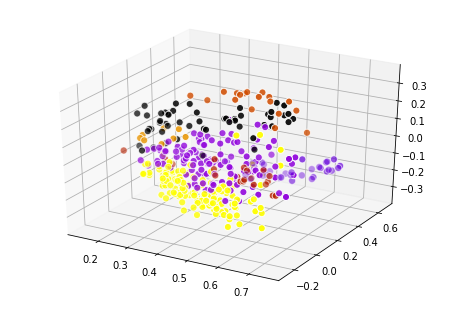

In [148]:
model = AgglomerativeClustering(n_clusters=7)
model.fit(X.toarray())
y_plot = pd.DataFrame(model.labels_)
# plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xpca_plot[0], Xpca_plot[1], Xpca_plot[2], c=y_plot[0], s=50,
           cmap="gnuplot",
           edgecolor="white", linewidth=1)

### Plot al modelelor care folosesc PCA

AgglomerativeClustering {'n_clusters': 7} -- Dimensions: 400
AgglomerativeClustering {'n_clusters': 20} -- Dimensions: 60
AgglomerativeClustering {'n_clusters': 2} -- Dimensions: 10
AgglomerativeClustering {'n_clusters': 2} -- Dimensions: 5
AgglomerativeClustering {'n_clusters': 2} -- Dimensions: 3


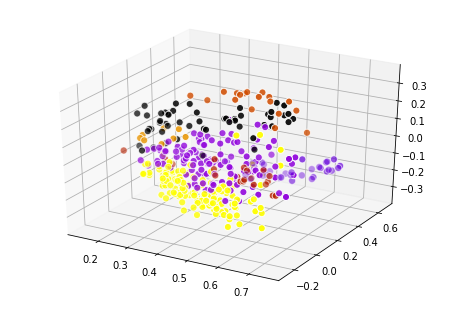

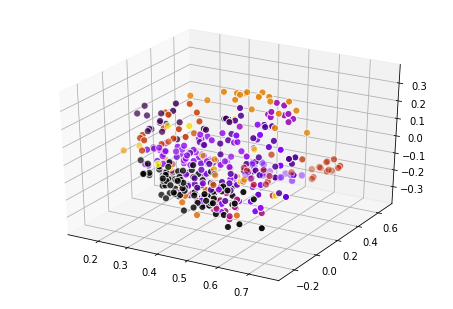

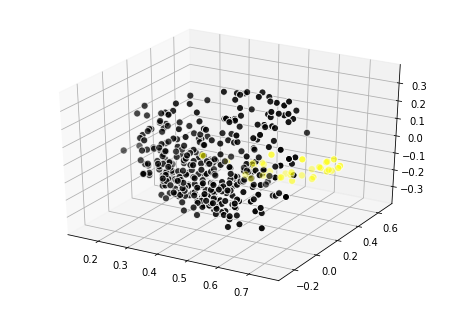

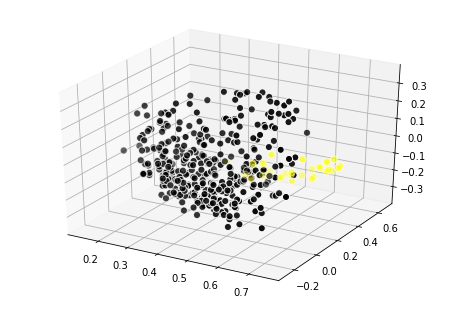

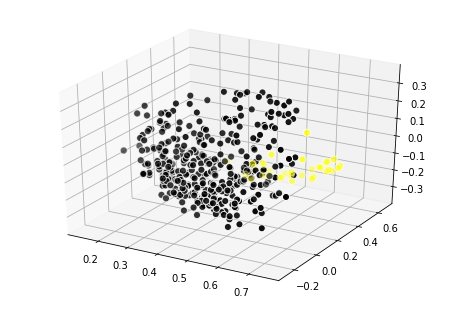

In [149]:
models_list = [
    (AgglomerativeClustering, {'n_clusters': 7}, 400),
    (AgglomerativeClustering, {'n_clusters': 20}, 60),
    (AgglomerativeClustering, {'n_clusters': 2}, 10),
    (AgglomerativeClustering, {'n_clusters': 2}, 5),
    (AgglomerativeClustering, {'n_clusters': 2}, 3)
]
for i, (Model, kwargs, dimensions) in enumerate(models_list):
    print(Model.__name__, kwargs, "-- Dimensions:", dimensions)
    clf = TruncatedSVD(n_components=dimensions)
    Xpca = clf.fit_transform(X)
    model = Model(**kwargs)
    model.fit(Xpca)
    y_plot = pd.DataFrame(model.labels_)
    fig = plt.figure(i)
    ax = Axes3D(fig)
    ax.scatter(Xpca_plot[0], Xpca_plot[1], Xpca_plot[2], c=y_plot[0], s=50,
           cmap="gnuplot",
           edgecolor="white", linewidth=1)

# Concluzii

Putem deduce, astfel, ca rezultatele in cazul clasificarii sunt foarte bune.
In cazul clustering-ului se observa ca nu se face o clusterizare foarte buna daca luam in considerare autorii. Dar, putem spune ca poate clusterizarea se face dupa un alt principiu, si nu dupa autori.

# !!!!Nu au fost label-uite plot-urile pentru ca nu reprezinta nimic cele 3 axe (fiindca a fost redusa dimensionalitatea)

# !!!! Nu am aplicat NGRAMS pentru ca nu am destula putere de procesare. Am incercat acest lucru dar mi s-a blocat laptop-ul. Exista posibilitatea ca rezultatele sa se imbunatateasca (sau nu) prin utilizrea ngrams.